# Comparing ERA5 and CRU-TS
Someone sent a plot suggesting that ERA5 has a $>2^oC$ average cold bias with respect to observations, in coastal cells in May and August.
CRU-TS appeared to match observations much better (CRU-TS is gridded data that interpolated a set of observations).

The data have already been aggregated by month, using "Agg_ERA5_and_CRUTS.py".

Select grid-cells that:
* are hot - defined as Tmax > 20 in CRU-TS
* are coastal / not coastal

Show:
* Maps of the differences between the datasets.
* Area averaged differences between ERA5 and CRU-TS, for the above subsets of the field


## Data loading and formatting

In [1]:
import xarray as xr
import scipy
import numpy as np
from pathlib import Path

In [76]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

In [3]:
# Load my monthly averaged data - see 'Agg_ERA5_and_CRUTS.ipynb'
da_era5 = xr.open_dataset("data/era5_t2m_mavg.nc")
da_cruts_tmp = xr.open_dataset("data/cruts_tmp_mavg.nc")
da_cruts_tmx = xr.open_dataset("data/cruts_tmx_mavg.nc")

In [4]:
# get the ERA5 land-sea mask
era5_lsm = xr.open_dataset("/gws/nopw/j04/bas_climate/data/ecmwf/era5/invariant/era5_invariant_lsm.nc")

In [5]:
# make the lsm match the data
era5_lsm = era5_lsm.squeeze().drop("time").rename({"latitude": "lat", "longitude": "lon"})

In [6]:
# realign the data to be centered on 0 longitude
if da_era5.lon.min() >= 0:
    da_era5 = da_era5.assign_coords(lon=(((da_era5.lon + 180) % 360) - 180))
if era5_lsm.lon.min() >= 0:
    era5_lsm = era5_lsm.assign_coords(lon=(((era5_lsm.lon + 180) % 360) - 180))

In [7]:
# re-sort the axes
da_era5 = da_era5.sortby(['lon', 'lat', 'month'])
era5_lsm = era5_lsm.sortby(['lon', 'lat'])

In [8]:
# drop ocean
da_era5 = da_era5.where(era5_lsm["lsm"])

In [14]:
# convert ERA5 to Celsius from Kelvin
da_era5["t2m"] = da_era5["t2m"] - 273.15

In [9]:
da_cruts_tmx

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, month: 12)
Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tmx      (month, lat, lon) float32 ...
    stn      (month, lat, lon) float64 ...

## Selecting appropriate grid-cells
I have selected coastal cells as cells adjacent to a change in the ERA5 land mask in either direction.

In [10]:
# quickly identify cells that are coastal, as cells where the land mask changes
da_coast = np.logical_or(era5_lsm["lsm"].differentiate("lat")!=0, era5_lsm["lsm"].differentiate("lon")!=0)

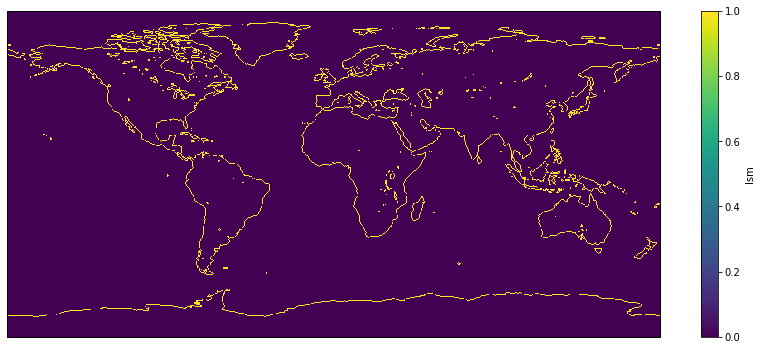

In [11]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
da_coast.plot()

In [12]:
# show locations where CRU-TS tmax > 20
tmx_mask = (da_cruts_tmx["tmx"] > 20)

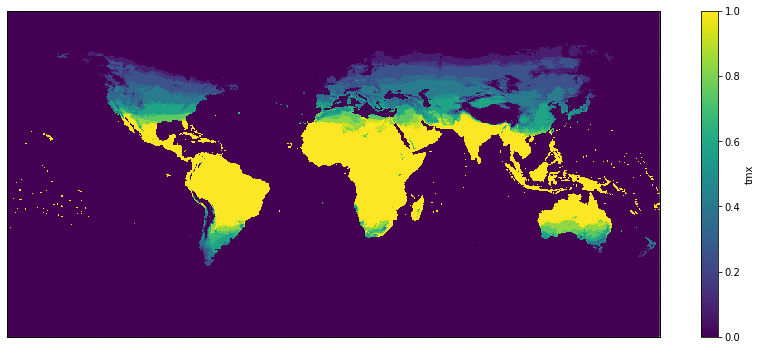

In [100]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
tmx_mask.mean("month").plot()

## Comparing the datasets

In [19]:
# take the difference between ERA5 and CRU-TS
da_diff = (da_era5["t2m"] - da_cruts_tmp["tmp"])

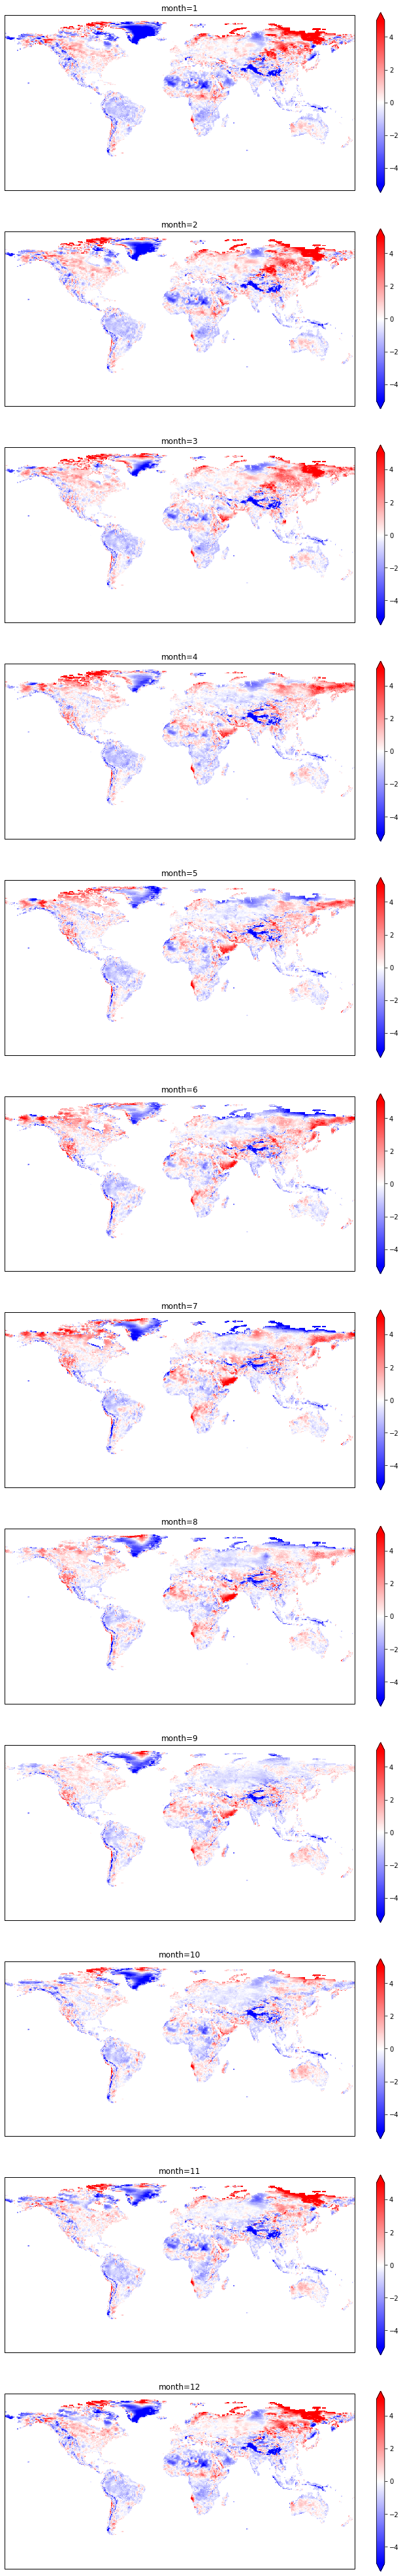

In [23]:
# show the difference for each month

norm = mpl.colors.Normalize(vmin=-5, vmax=5)

fig = plt.figure(figsize=(12, 6*12))

for month in range(1,13):
    ax = fig.add_subplot(12, 1, month, projection=ccrs.PlateCarree())
    da_diff.sel(month=month).plot(norm=norm, cmap='bwr')
    ax.set_title(f"month={month}")

There are clearly some locations with large differences between the datasets.

In [89]:
da_diff_gt20 = da_diff.where(da_cruts_tmx["tmx"]>20)
da_diff_gt20_coastal = da_diff_gt20.where(da_coast)
da_diff_coastal = da_diff.where(da_coast)

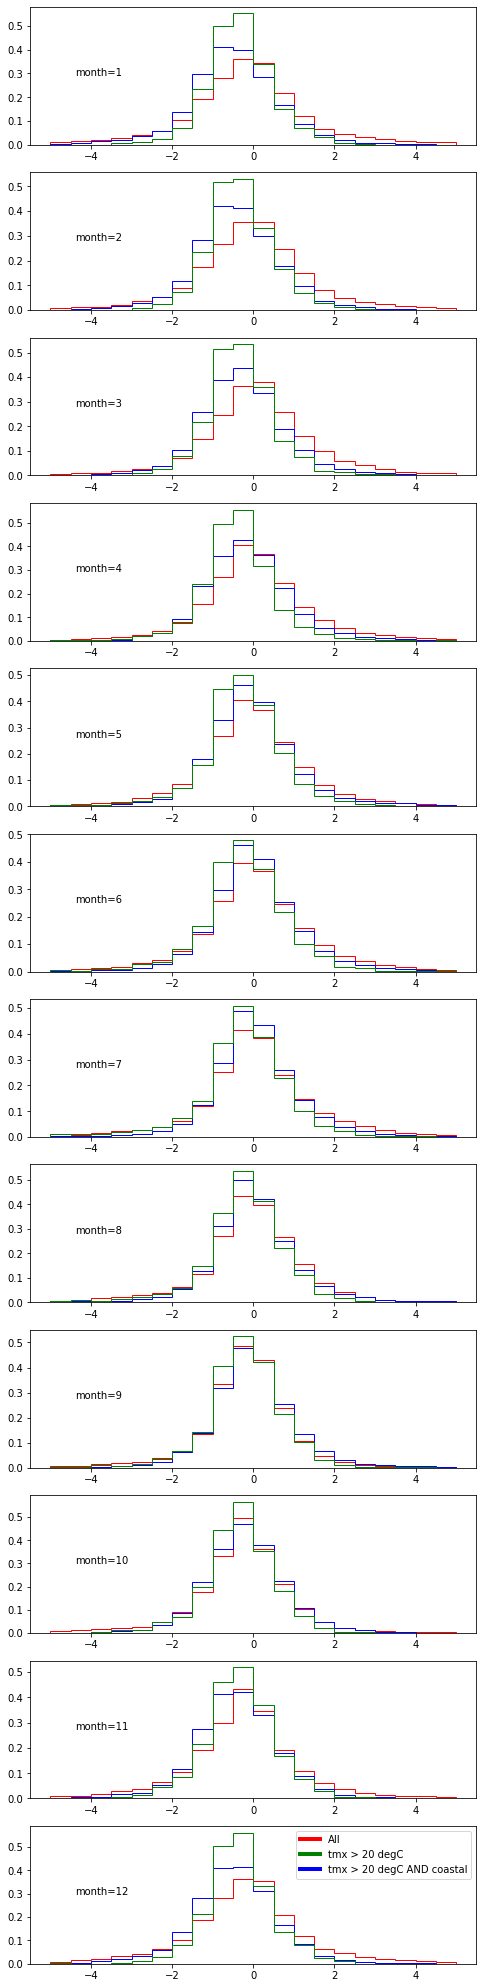

In [79]:
# show the difference for each month, as a histogram
# show only places with tmax > 20 degC
# AND which are coastal



bins = np.linspace(-5,5,21)
fig = plt.figure(figsize=(8, 3*12))
for month in range(1,13):
    ax = fig.add_subplot(12, 1, month)
    da_diff.sel(month=month).plot.hist(
        bins=bins, 
        label="All",
        histtype="step",
        ax=ax,
        color='r',
        density=True
    )
    da_diff_gt20.sel(month=month).plot.hist(
        bins=bins, 
        label="tmx > 20 degC",
        histtype="step",
        ax=ax,
        color='b',
        density=True
    )
    da_diff_gt20_coastal.sel(month=month).plot.hist(
        bins=bins, 
        label="tmx > 20 degC AND coastal",
        histtype="step",
        ax=ax,
        color='g',
        density=True
    )
    ax.set_title("")
    plt.text(0.1, 0.5, f"month={month}", transform=ax.transAxes)

custom_lines = [Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='b', lw=4)]
ax.legend(custom_lines, ['All', 'tmx > 20 degC', 'tmx > 20 degC AND coastal'])
    

Let's take an area average.

In [86]:
lat_area_weights = np.cos(np.deg2rad(da_diff.lat))

Text(0, 0.5, 'bias (degC)')

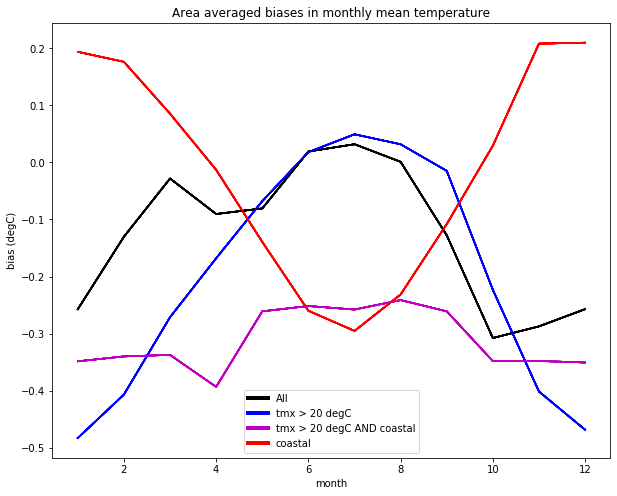

In [98]:
# show the area averaged difference for each month, as a line graph
# show only places with tmax > 20 degC
# AND which are coastal

fig, ax = plt.subplots(figsize=(10,8))

for month in range(1,13):
    da_diff.weighted(lat_area_weights).mean(["lat", "lon"]).plot(
        color='k'
    )
    da_diff_gt20.weighted(lat_area_weights).mean(["lat", "lon"]).plot(
        color='b'
    )
    da_diff_gt20_coastal.weighted(lat_area_weights).mean(["lat", "lon"]).plot(
        color='m'
    )
    da_diff_coastal.weighted(lat_area_weights).mean(["lat", "lon"]).plot(
        color='r'
    )

custom_lines = [Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='m', lw=4),
                Line2D([0], [0], color='red', lw=4)
]
ax.legend(custom_lines, ['All', 'tmx > 20 degC', 'tmx > 20 degC AND coastal', 'coastal'])
plt.title("Area averaged biases in monthly mean temperature")
plt.ylabel("bias (degC)")

## Conclusions
* There are some large differences in the monthly mean temperature field between CRU-TS 4.04 and ERA5.
* However, the area averaged differences are $<1^oC$ for all months.
* This is still true when only hot locations (monthly max temperature $>20^oC$) are selected, and when only coastal locations are selected.